In [13]:
# to import from parent directory
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import get_lags
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error

In [15]:
full = pd.read_csv('../normalised_growth.csv', index_col=0, header=[0] ,parse_dates=True)
full.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.635906,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.543396,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.638258,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.640650,NaN,NaN,NaN


In [16]:
sliced = full.loc["1948-01-01":"2019-01-01"]
sliced.shape

(853, 32)

In [17]:
length = len(full.loc["1948-01-01":])
val_start = round(length * 0.8) # validation set not needed for VAR
test_start = round(length * 0.9)    

In [18]:
core_series = ["CPIAUCSL", "A191RO1Q156NBEA", "UNRATE"]

core = sliced[core_series]

train = core.iloc[:test_start-1]
test = core.iloc[test_start:]

print(train.shape)

(767, 3)


In [19]:
model = VAR(train, freq='MS')
model.select_order(15).summary()

,AIC,BIC,FPE,HQIC
0,-0.01658,0.001864,0.9836,-0.009473
1,-11.72,-11.65,8.095e-06,-11.70
2,-12.83,-12.70*,2.679e-06,-12.78
3,-12.84,-12.65,2.657e-06,-12.77
4,-12.84,-12.60,2.648e-06,-12.75
5,-12.89,-12.60,2.520e-06,-12.78
6,-12.89,-12.54,2.533e-06,-12.75
7,-12.89,-12.48,2.534e-06,-12.73
8,-12.91,-12.45,2.462e-06,-12.74
9,-12.92,-12.40,2.454e-06,-12.72


In [20]:
results = model.fit(maxlags=15, ic='bic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 02, Sep, 2019
Time:                     21:51:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -12.5397
Nobs:                     765.000    HQIC:                  -12.6180
Log likelihood:           1609.67    FPE:                3.15341e-06
AIC:                     -12.6670    Det(Omega_mle):     3.06841e-06
--------------------------------------------------------------------
Results for equation CPIAUCSL
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.001498         0.005213           -0.287           0.774
L1.CPIAUCSL                1.361167         0.033740           40.342           0.000
L1.A191RO1Q156NBEA         0.002069  

In [9]:
from utils import plot_var_forc

In [99]:
def plot_forecast_custom(results, steps, previous = 20, alpha=0.05, plot_stderr=True):
    mid, lower, upper = results.forecast_interval(results.y, steps=steps, alpha=0.05)
    fig = plot_var_forc(results.y[-previous:], mid, lower, upper, names=results.names, plot_stderr=plot_stderr)
    return fig


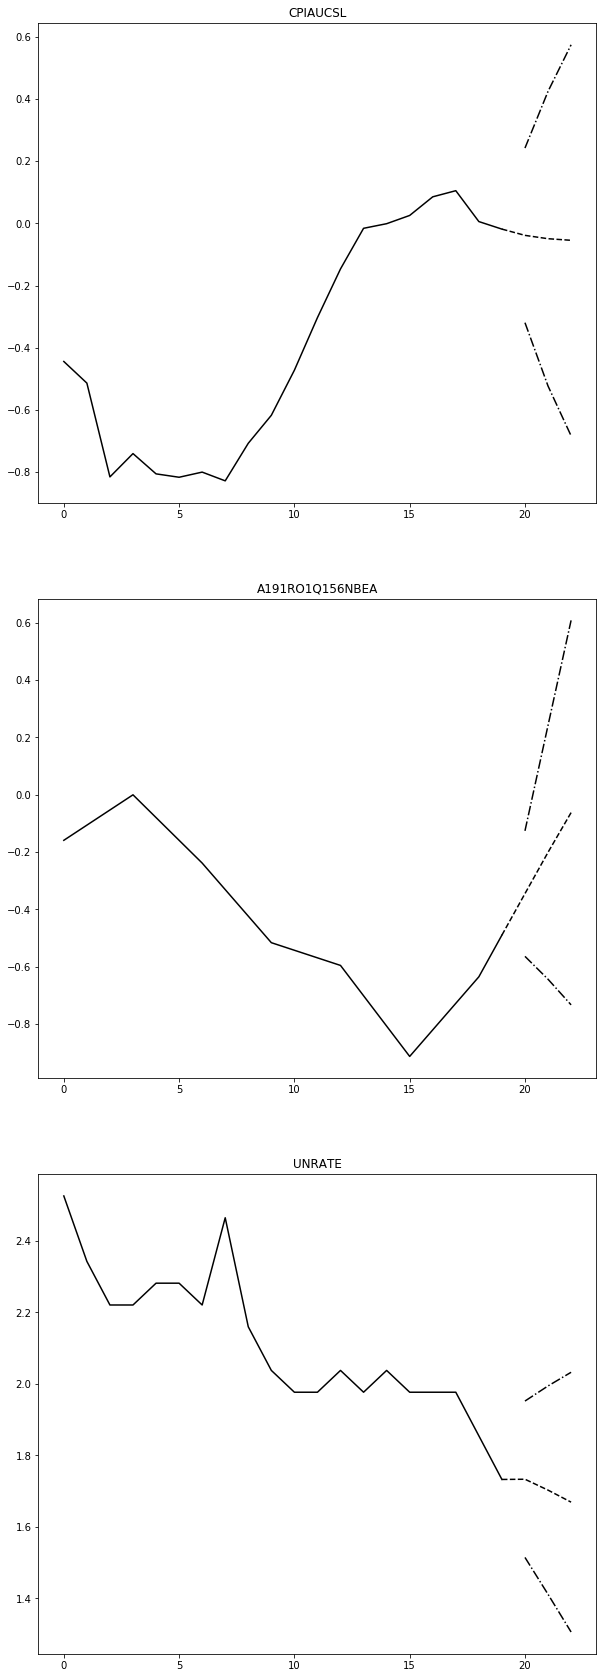

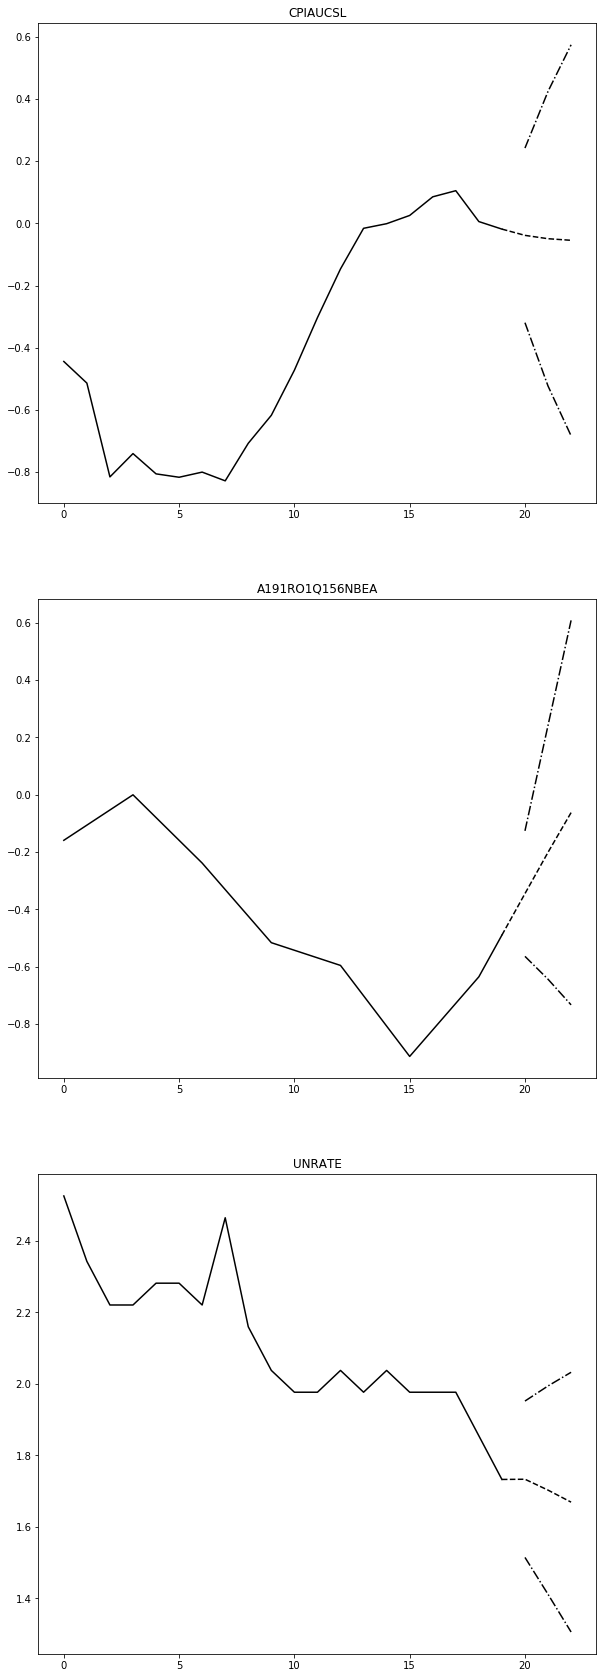

In [100]:
plot_forecast_custom(results, steps = 3)

In [21]:
lag_order = results.k_ar
forecasts = np.empty((len(test) - lag_order, 3))
# forecasts = np.empty((len(test), 3))

# for first two lags
# forecast = results.forecast(train.values[-2:], steps=1)
# forecasts[0] = forecast
# forecast = results.forecast(np.concatenate((train.values[-1].reshape((1, 3)), test.values[0].reshape(1, 3)), axis=0), steps=1)
# forecasts[1] = forecast

for i in range(len(test) - lag_order):
    forecast = results.forecast(test.values[i:lag_order + i], steps=1)
    forecasts[i] = forecast
#     forecasts[i + lag_order] = forecast

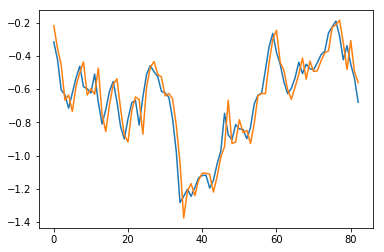

In [22]:
plt.plot(test.values[lag_order:,0])
plt.plot(forecasts[:,0])

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from utils import save_obj

In [24]:
mse = mean_squared_error(forecasts, test[lag_order:])
print("Average RMSE on test set: " + str(sqrt(mse)))

Average RMSE on test set: 0.0876118469891554


In [125]:
save_obj(forecasts, "../Forecasts/VAR_1")

In [117]:
save_obj(test, "../Forecasts/testdata")

In [98]:
len(test.values[lag_order:,0])

83

# Multi-step ahead

In [26]:
steps = 3

multi_forecasts = np.empty((len(test) - lag_order - steps + 1, 3))

for i in range(len(test) - lag_order - steps + 1):
    forecast_1 = results.forecast(test.values[i:lag_order + i], steps=1)
    forecast_2 = results.forecast(np.concatenate((test.values[i + 1:lag_order + i], forecast_1)), steps=1) # 2 step
    forecast_3 = results.forecast(np.concatenate((test.values[i + 2:lag_order + i], forecast_1, forecast_2)), steps=1) # 3 step
    multi_forecasts[i] = forecast_3 # last one

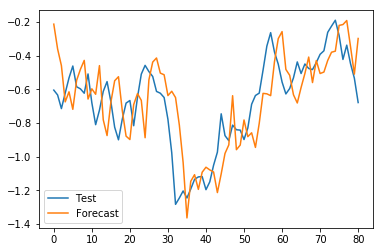

In [27]:
plt.plot(test.values[lag_order+steps - 1:,0])
plt.plot(multi_forecasts[:,0])
plt.legend(("Test", "Forecast"), facecolor="white")

In [29]:
mse = mean_squared_error(multi_forecasts, test[lag_order+steps-1:])
print("Average RMSE on test set: " + str(sqrt(mse)))

Average RMSE on test set: 0.20084500468319336


In [25]:
len(test.values[lag_order+steps-1:,0])

81

In [30]:
save_obj(multi_forecasts, "../Forecasts/VAR_3")